### This notebook is an aggregation of a single utility used for extracting individual words from the full image.

Refer to the "A* Path Planning Line Segmentation Algorithm" notebook for detailed code walkthrough

In [33]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import sobel
import numpy as np
from skimage.filters import threshold_otsu
from skimage.util import invert
from heapq import *

def extract_words_from_image(input_image):
    img = rgb2gray(imread(input_image))
    
    # find the horizontal projection for line segment segregation
    sobel_image = sobel(img)
    hpp = horizontal_projections(sobel_image)
    
    #find the midway where we can make a threshold and extract the peaks regions
    #divider parameter value is used to threshold the peak values from non peak values.
    peaks = find_peak_regions(hpp)
    peaks_index = np.array(peaks)[:,0].astype(int)
    
    segmented_img = np.copy(img)
    r,c = segmented_img.shape
    for ri in range(r):
        if ri in peaks_index:
            segmented_img[ri, :] = 0
            
    hpp_clusters = get_hpp_walking_regions(peaks_index)
    
    binary_image = get_binary(img)

    for cluster_of_interest in hpp_clusters:
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        road_blocks = get_road_block_regions(nmap)
        road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
        #create the doorways
        for index, road_blocks in enumerate(road_blocks_cluster_groups):
            window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
            binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0
    
    #now that everything is cleaner, its time to segment all the lines using the A* algorithm
    line_segments = []
    for i, cluster_of_interest in enumerate(hpp_clusters):
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
        offset_from_top = cluster_of_interest[0]
        path[:,0] += offset_from_top
        line_segments.append(path)

    ## add an extra line to the line segments array which represents the last bottom row on the image
    last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), np.arange(img.shape[1]))).astype(int), axis=0)
    line_segments.append(last_bottom_row)
    
    line_images = []
    line_count = len(line_segments)
    for line_index in range(line_count-1):
        line_image = extract_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
        line_images.append(line_image)
        
    # exract words from all lines
    line_words = []
    for line_image in line_images:
        line_words.append(extract_words_from_lines(line_image))
     
    return line_words

def horizontal_projections(image):
    return np.sum(image, axis=1)

def vertical_projections(image):
    return np.sum(image, axis=0)

def find_peak_regions(hpp, divider=2):
    threshold = (np.max(hpp)-np.min(hpp))/divider
    peaks = []
    peaks_index = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

#group the peaks into walking windows
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

#a star path planning algorithm
def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    return road_blocks

def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

def extract_line_from_image(image, lower_line, upper_line):
    lower_boundary = np.min(lower_line[:, 0])
    upper_boundary = np.min(upper_line[:, 0])
    img_copy = np.copy(image)
    r, c = img_copy.shape
    for index in range(c-1):
        img_copy[0:lower_line[index, 0], index] = 255
        img_copy[upper_line[index, 0]:r, index] = 255
    
    return img_copy[lower_boundary:upper_boundary, :]

def extract_words_from_lines(line_image):
    ## now that we have lines, lets segregate them into words.
    thresh = threshold_otsu(line_image)
    binary = line_image > thresh

    # find the vertical projection by adding up the values of all pixels along rows
    vertical_projection = vertical_projections(binary)
    
    height = line_image.shape[0]

    ## we will go through the vertical projections and 
    ## find the sequence of consecutive white spaces in the image
    whitespace_lengths = []
    whitespace = 0
    for vp in vertical_projection:
        if vp == height:
            whitespace = whitespace + 1
        elif vp != height:
            if whitespace != 0:
                whitespace_lengths.append(whitespace)
            whitespace = 0 # reset whitepsace counter. 

    print("whitespaces:", whitespace_lengths)
    avg_white_space_length = np.mean(whitespace_lengths)
    print("average whitespace lenght:", avg_white_space_length)
    
    ## find index of whitespaces which are actually long spaces using the avg_white_space_length
    whitespace_length = 0
    divider_indexes = []
    for index, vp in enumerate(vertical_projection):
        if vp == height:
            whitespace_length = whitespace_length + 1
        elif vp != height:
            if whitespace_length != 0 and whitespace_length > avg_white_space_length:
                divider_indexes.append(index-int(whitespace_length/2))
                whitespace_length = 0 # reset it

    print(divider_indexes)
    
    # lets create the block of words from divider_indexes
    divider_indexes = np.array(divider_indexes)
    dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
    
    words = []
    for index, window in enumerate(dividers):
        words.append(line_image[:,window[0]:window[1]])
        
    return words

whitespaces: [285, 9, 8, 6, 29, 7, 101, 12, 15, 18, 9, 16, 17, 53, 61, 8, 11, 13]
average whitespace lenght: 64.61939853222611
[143, 877, 1243, 1487, 1659]
whitespaces: [281, 13, 10, 27, 14, 8, 15, 11, 7, 130, 6, 8, 18, 5, 8, 7, 84, 5, 12, 19]
average whitespace lenght: 64.02921208323588
[141, 685, 1117, 1626]
whitespaces: [290, 10, 117, 3, 5, 10, 5, 16, 4, 22, 11, 28, 129, 10, 7, 9, 16, 20, 12, 15, 15, 3, 27]
average whitespace lenght: 63.191849394266626
[145, 510, 1104, 1418, 1932]
whitespaces: [593, 248, 74, 90, 533, 796]
average whitespace lenght: 269.7245508538912
[297, 760, 1237, 1949]


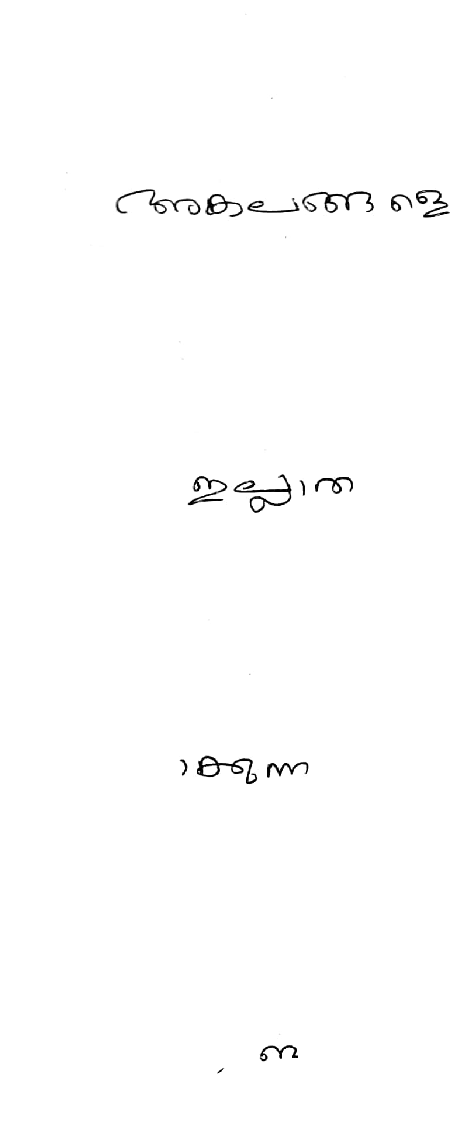

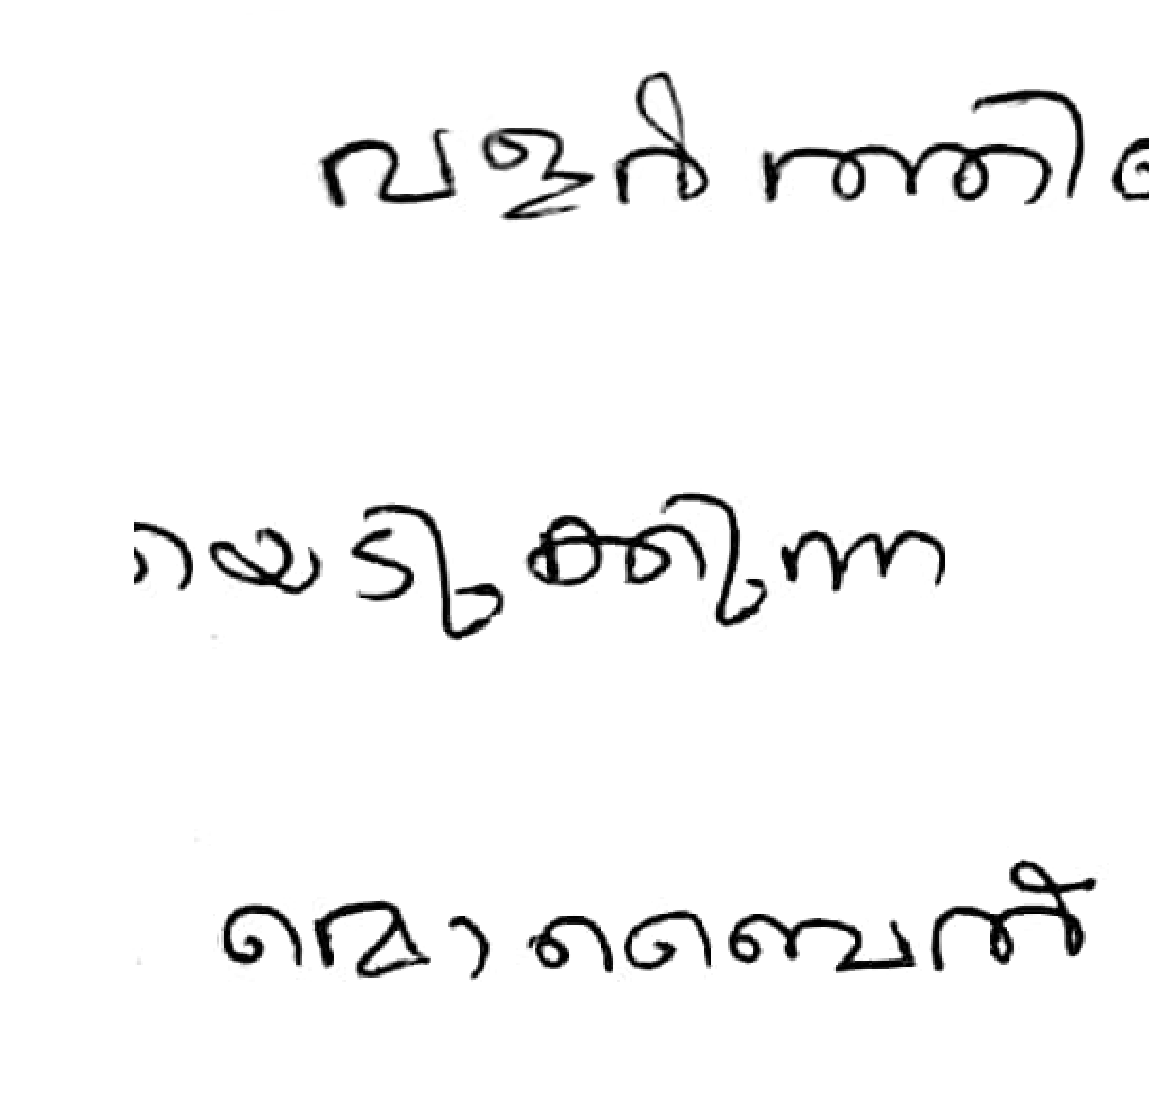

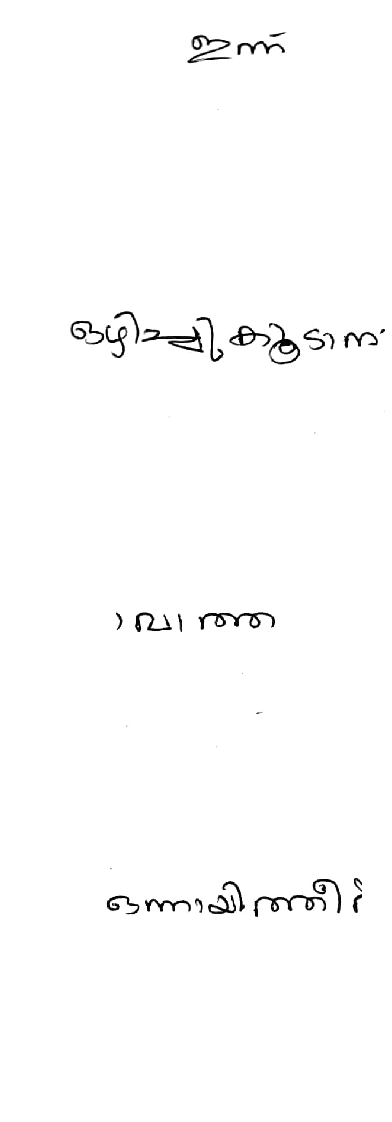

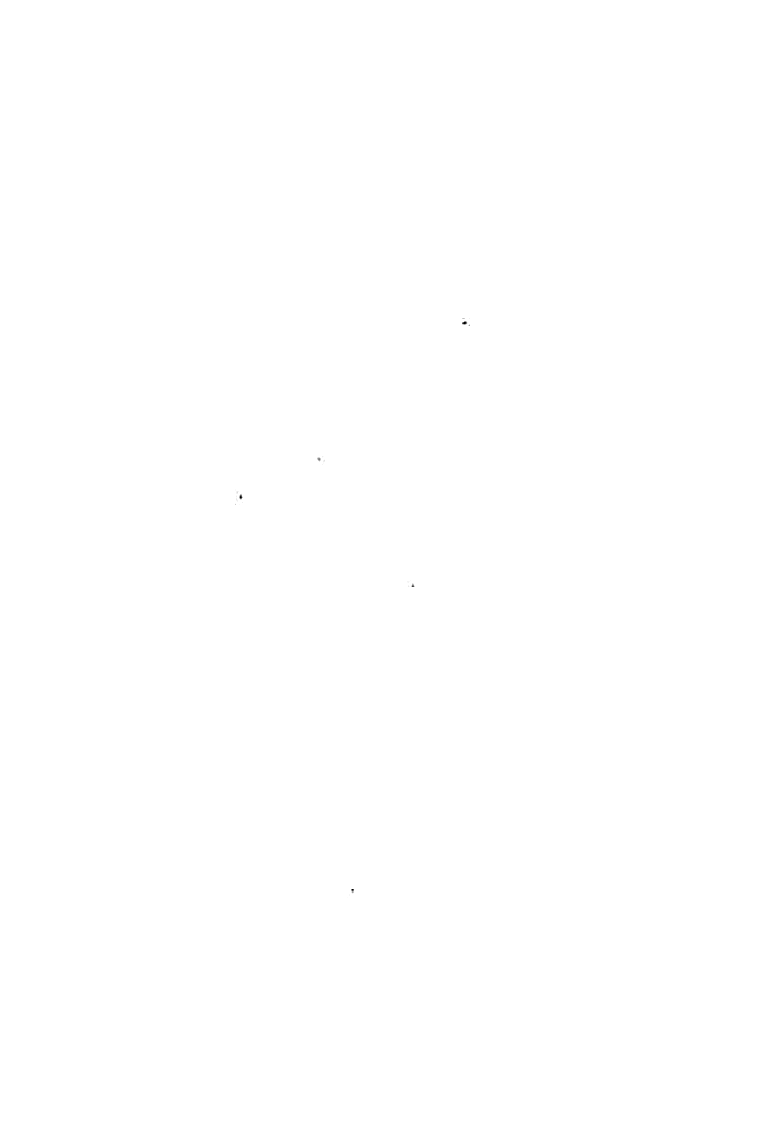

In [37]:
line_words = extract_words_from_image("test4.jpg")

for word_images in line_words:
    fig, ax = plt.subplots(figsize=(20,20), nrows=len(word_images))
    for index, word in enumerate(word_images):
        ax[index].axis("off")
        ax[index].imshow(word, cmap="gray")